In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# params
batch_size = 128 
epochs = 10    
lr = 0.1      
device = 'cuda'

0.1%

69.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

88.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


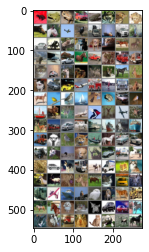

In [3]:
# Data Loading
data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
## network and optimizer
num_inputs = 3072
num_outputs = 10

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 3)
        self.conv2 = nn.Conv2d(192, 384, 3)
        self.conv3 = nn.Conv2d(384, 4, 3)

        self.mlp1 = nn.Conv2d(192, 192, 1)
        self.mlp2 = nn.Conv2d(384, 384, 1)
        self.mlp3 = nn.Conv2d(4, 4, 1)

        self.maxpool = nn.MaxPool2d(3, stride=2)
        self.drop = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(192)
        self.bn2 = nn.BatchNorm2d(384)
        self.bn3 = nn.BatchNorm2d(4)
        self.globalpool = nn.AdaptiveAvgPool2d((1,1))
        self.flat = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.mlp1(x))
        x = F.relu(self.mlp1(x))
        x = self.maxpool(x)
        ##x = self.drop(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.mlp2(x))
        x = F.relu(self.mlp2(x))
        x = self.maxpool(x)
        ##x = self.drop(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.mlp3(x))
        x = F.relu(self.mlp3(x))
        x = self.globalpool(x)
        
        x = self.flat(x)

        return x

network = Net(num_inputs, num_outputs).to(device)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [5]:
def transform(data, device = device):
    data.to(device)
    transformed = []
    rotation = []
    
    for image in data:
        transformed.append(image)
        rotation.append(0)

        pic = torch.transpose(image,1,2)
        pic = torch.flip(pic,[2])
        transformed.append(pic)
        rotation.append(1)

        pic = torch.flip(image,[1])
        pic = torch.flip(pic,[2])
        transformed.append(pic)
        rotation.append(2)

        pic = torch.flip(image,[2])
        pic = torch.transpose(pic,1,2)
        transformed.append(pic)
        rotation.append(3)

        rot = torch.LongTensor(rotation)

    return (torch.stack(transformed), rot)

#batchi = iter(train_loader)
#data, target = batchi.next()
#g,h = transform(data)
#imshow(torchvision.utils.make_grid(g))

In [6]:
def train(epochs):
    network.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            #data, target = Variable(data).to(device), Variable(target).to(device)
            data, target = transform(data)
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = network(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))


def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = transform(data)
        output = network(data.to(device))
        test_loss += F.cross_entropy(output, target.to(device), reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1].to(device) # get the index of the max log-probability
        correct += pred.eq(target.to(device).data.view_as(pred)).to(device).sum()

    test_loss /= len(test_loader.dataset)*4
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset)*4,
        100 * correct / (len(test_loader.dataset)*4)))


In [14]:
train(epochs)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.332058
Train Epoch: 1 [51200/50000 (26%)]	Loss: 0.416266
Train Epoch: 1 [102400/50000 (51%)]	Loss: 0.283384
Train Epoch: 1 [153600/50000 (77%)]	Loss: 0.405929
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.332773
Train Epoch: 2 [51200/50000 (26%)]	Loss: 0.298993
Train Epoch: 2 [102400/50000 (51%)]	Loss: 0.286913
Train Epoch: 2 [153600/50000 (77%)]	Loss: 0.326790
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.312727
Train Epoch: 3 [51200/50000 (26%)]	Loss: 0.283391
Train Epoch: 3 [102400/50000 (51%)]	Loss: 0.314339
Train Epoch: 3 [153600/50000 (77%)]	Loss: 0.371519
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.329676
Train Epoch: 4 [51200/50000 (26%)]	Loss: 0.277422
Train Epoch: 4 [102400/50000 (51%)]	Loss: 0.307517
Train Epoch: 4 [153600/50000 (77%)]	Loss: 0.281124
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.271717
Train Epoch: 5 [51200/50000 (26%)]	Loss: 0.237354
Train Epoch: 5 [102400/50000 (51%)]	Loss: 0.300310
Train Epoch: 5 [153600/50000 (77%)]	Loss: 0.312376
Train Epoch: 6 

In [17]:
test()


Test set: Average loss: 1.2624, Accuracy: 28095/40000 (70%)



In [1]:
import torch.nn as nn
from collections import OrderedDict

class NIN_block(nn.Module):
    def __init__(self, in_ch1, out_ch1, out_ch2, out_ch3, ksize):
        super(NIN_block, self).__init__()
        
        pad = int((ksize-1)/2)
        
        self.block = nn.Sequential(OrderedDict([
                ('main_conv', nn.Conv2d(in_ch1, out_ch1, ksize, padding=pad)),
                ('main_bnorm', nn.BatchNorm2d(out_ch1)),
                ('main_relu', nn.ReLU()), 
                ##### 
                ('mlp_conv1', nn.Conv2d(out_ch1, out_ch2, 1)),
                ('mlp_bnorm1', nn.BatchNorm2d(out_ch2)),
                ('mlp_relu1', nn.ReLU()), 
                #####
                ('mlp_conv2', nn.Conv2d(out_ch2, out_ch3, 1)),
                ('mlp_bnorm2', nn.BatchNorm2d(out_ch3)),
                ('mlp_relu2', nn.ReLU())]))

    def forward(self, x):
        x = self.block(x)
        return x


class RotNet(nn.Module):
    def __init__(self, in_channels, num_nin_blocks, out_classes):
        super(RotNet, self).__init__()
        
        self.rotnet_layer_names = []
        for i in range(num_nin_blocks):
            self.rotnet_layer_names.append('nin_block'+str(i+1))
            if i < 2:
                self.rotnet_layer_names.append('maxpool'+str(i+1))
        
        self.rotnet = nn.ModuleDict({})

        self.rotnet['nin_block1'] = NIN_block(in_channels, 192, 160, 96, 5)
        self.rotnet['maxpool1'] = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.rotnet['nin_block2'] = NIN_block(96, 192, 192, 192, 5)
        self.rotnet['maxpool2'] = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        assert num_nin_blocks > 2
        for i in range(2,num_nin_blocks):
            nin_block_name = 'nin_block' + str(i+1)
            out_ch3 = 192
            # code below can be uncommented to make this model exactly like in NiN paper
            # after removing the fully connected layer as well
            # if i+1 == num_nin_blocks:
            #     out_ch3 = out_classes
            self.rotnet[nin_block_name] = NIN_block(192, 192, 192, out_ch3, 3)

        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flat = nn.Flatten()
        self.fc = nn.Linear(192, out_classes)


    def forward(self, x, ret_block_nums):
        # ret_blocks: list of numbers where 
        # each number corresponds to nin block number
        # who ouput you want in features
        ret_layer_names = []
        for i in ret_block_nums:
            if i < 3:
                ret_layer_names.append('maxpool'+str(i))
            else:
                ret_layer_names.append('nin_block'+str(i))
        
        ret_feats = {}
        for layer in self.rotnet_layer_names:
            x = self.rotnet[layer](x)
            if layer in ret_layer_names:
                ret_feats[layer] = x

        x = self.glob_avg_pool(x)
        x = self.flat(x)
        x = self.fc(x)
        
        ret_block_num2names = dict(zip(ret_block_nums, ret_layer_names)) 

        return x, ret_feats, ret_block_num2names
        

class NonLinearClassifier(nn.Module):
    def __init__(self, in_channels, out_classes):
        super(NonLinearClassifier, self).__init__()
        
        self.block = nn.Sequential(OrderedDict([
                ('nin_block3', NIN_block(in_channels, 192, 192, 192, 3)),
                ('glob_avg_pool', nn.AdaptiveAvgPool2d((1,1))),
                ('flat', nn.Flatten()),
                ('fc', nn.Linear(192, out_classes))]))

    def forward(self, x):
        x = self.block(x)
        return x


class ConvClassifier(nn.Module):
    def __init__(self, ):
        super(ConvClassifier, self).__init__()
        
        self.block = nn.Sequential(OrderedDict([
                ('flat', nn.Flatten()),
                ('fc1', nn.Linear(in_channels, 200)),
                ('fc1_bnorm', nn.BatchNorm2d(200)),
                ('fc1_relu', nn.ReLU()), 
                ##### 
                ('fc2', nn.Linear(200, 200)),
                ('fc2_bnorm', nn.BatchNorm2d(200)),
                ('fc2_relu', nn.ReLU()),
                #####
                ('fc3', nn.Linear(200, out_classes))]))

    def forward(self, x):
        x = self.block(x)
        return x

In [2]:
import torch
network = RotNet(3,5,4)
a = torch.randn(1,3,32,32)
ret_nums = [1,2,3,4,5]
out, feats, num2names = network(a, ret_nums)
print(out.shape)
for i in range(5):
    print(feats[num2names[ret_nums[i]]].shape)

torch.Size([1, 4])
torch.Size([1, 96, 16, 16])
torch.Size([1, 192, 8, 8])
torch.Size([1, 192, 8, 8])
torch.Size([1, 192, 8, 8])
torch.Size([1, 192, 8, 8])


In [5]:
num2names

{1: 'maxpool1',
 2: 'nin_block2',
 3: 'nin_block3',
 4: 'nin_block4',
 5: 'nin_block5'}

In [3]:
feats[0].shape

torch.Size([1, 96, 16, 16])

In [15]:
print(network)

RotNet(
  (rotnet): Sequential(
    (nin_block1): NIN_block(
      (block): Sequential(
        (main_conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (main_bnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (main_relu): ReLU()
        (mlp_conv1): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
        (mlp_bnorm1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mlp_relu1): ReLU()
        (mlp_conv2): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
        (mlp_bnorm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mlp_relu2): ReLU()
      )
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (nin_block2): NIN_block(
      (block): Sequential(
        (main_conv): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (main_bnorm): BatchNorm2d(96, eps

In [3]:
# train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.ToTensor()

# trainset = datasets.CIFAR10(root='results/', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='results/', train=False, download=True, transform=test_transform)

# train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)
test_iterator = iter(test_loader)

data, labels = test_iterator.next()

Files already downloaded and verified


In [4]:
data[1]

tensor([[[0.9216, 0.9059, 0.9098,  ..., 0.9137, 0.9137, 0.9098],
         [0.9333, 0.9216, 0.9216,  ..., 0.9255, 0.9255, 0.9216],
         [0.9294, 0.9176, 0.9176,  ..., 0.9216, 0.9216, 0.9176],
         ...,
         [0.3412, 0.1686, 0.0745,  ..., 0.6627, 0.7137, 0.7373],
         [0.3216, 0.1804, 0.1412,  ..., 0.6824, 0.7255, 0.7333],
         [0.3333, 0.2431, 0.2275,  ..., 0.6588, 0.7059, 0.7294]],

        [[0.9216, 0.9059, 0.9098,  ..., 0.9137, 0.9137, 0.9098],
         [0.9333, 0.9216, 0.9216,  ..., 0.9255, 0.9255, 0.9216],
         [0.9294, 0.9176, 0.9176,  ..., 0.9216, 0.9216, 0.9176],
         ...,
         [0.3882, 0.2000, 0.0902,  ..., 0.7216, 0.7725, 0.7922],
         [0.3765, 0.2235, 0.1725,  ..., 0.7412, 0.7843, 0.7922],
         [0.3961, 0.2941, 0.2627,  ..., 0.7176, 0.7647, 0.7843]],

        [[0.9216, 0.9059, 0.9098,  ..., 0.9137, 0.9137, 0.9098],
         [0.9333, 0.9216, 0.9216,  ..., 0.9255, 0.9255, 0.9216],
         [0.9294, 0.9176, 0.9176,  ..., 0.9216, 0.9216, 0.